```
@beelzebruno
2022
```

In [4]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

plt.style.use('seaborn')

<hr />

# The Beer Route

<hr /><br />

Ok, its been five weeks now from the time I have started the whole process, by the time I am writing these lines, of course, anyway, since then I've been reviwing past contents from my bachelors which are also the foundations of algorithms and computer science, I am opening different notebooks with different implemented code to exercise and practice the algorithms || yes I know I could write once and import from a `src` module ||, but thats not the point of this repository. Here I am repeating same data structures in different time and self humor coding to exercice myself, my skill and my knowledge, through different kind of problems, some from code challenges from ther websites, some from books and some that i have created myself (see Highlands in this [notebook here](https://github.com/brunolcarli/GooGraph/blob/master/graph_search.ipynb)).

<br />

Ok, lets stop talking, I feel like i got some improvement since highlands, so lets have another try on graphs. I ~~love~~like having a beer during happy hours with my friends, and of course there are some pubs that I am more likely to drink at. Suppose it is my birthday and a I have selected eight from my favorite pubs and we have to drink one beer at each one without repeating locations, of course we should start on our most favorite and classic ever.

<br />

The favorite places are ploted on the map:

In [5]:
pub_geolocations = {
    'Jokers': (-25.4280205, -49.2723036),
    'Villa Bambu': (-25.4267986, -49.2758894),
    'Slainte': (-25.435735, -49.2873796),
    'Sheridans': (-25.4454165, -49.2969174),
    'Txapela': (-25.446419,-49.2983345),
    'Tatas': (-25.4374191, -49.2766666),
    'James': (-25.4334848, -49.2838167),
    'Blood Rock': (-25.424682, -49.2789355),
}


cwb_map = folium.Map(location=pub_geolocations['Villa Bambu'], zoom_start=14)
for k, v in pub_geolocations.items():
    folium.Marker(v, popup=k).add_to(cwb_map)

cwb_map

Out:

![cwb_beer_route](https://i.ibb.co/Y3BZtK6/cwb-beer-route.png)

Now instead of following booksand guides and pseudocode approaches, im gonna try to implement an approach by myself based on the other content a have followed until this moment.

Now lets think about simple nodes, which have their names and possibilities with their distances, just like highlands.

<br />

A Graph is a set of nodes built over a heuristic hashtable.

<br />

To walk through the nodes, I will implement a new data structure called `Cursor`, much like Russel & Norvig going to call an **Agent** maybe. I will use search algorithms search paths (edges) between the nodes, following some rules (like number of steps or even **cant repeat the same place twice** as stated on the abstraction). So the Cursor is the one who retain search and movement on the graph.

In [6]:
# Heuristic of the mean min walking distance in meters by google maps
pub_distances = {
    'Jokers': {
        'Jokers': 0,
        'Villa Bambu': 450,
        'Slainte': 2000,
        'Sheridans': 3500,
        'Txapela': 3700,
        'Tatas': 1500,
        'James': 1500,
        'Blood Rock': 900
    },
    'Villa Bambu': {
        'Jokers': 450,
        'Villa Bambu': 0,
        'Slainte': 1900,
        'Sheridans': 3500,
        'Txapela': 3600,
        'Tatas': 1500,
        'James': 1400,
        'Blood Rock': 450
    },
    'Slainte': {
        'Jokers': 2000,
        'Villa Bambu': 1900,
        'Slainte': 0,
        'Sheridans': 2000,
        'Txapela': 2100,
        'Tatas': 1300,
        'James': 500,
        'Blood Rock': 2000
    },
    'Sheridans': {
        'Jokers': 3500,
        'Villa Bambu': 3500,
        'Slainte': 2000,
        'Sheridans': 0,
        'Txapela': 170,
        'Tatas': 2300,
        'James': 2300,
        'Blood Rock': 3500
    },
    'Txapela': {
        'Jokers': 3700,
        'Villa Bambu': 3600,
        'Slainte': 2100,
        'Sheridans': 170,
        'Txapela': 0,
        'Tatas': 2500,
        'James': 2500,
        'Blood Rock': 3700
    },
    'Tatas': {
        'Jokers': 1500,
        'Villa Bambu': 1400,
        'Slainte': 1300,
        'Sheridans': 2300,
        'Txapela': 2500,
        'Tatas': 0,
        'James': 1100,
        'Blood Rock': 1700
    },
    'James': {
        'Jokers': 1500,
        'Villa Bambu': 1400,
        'Slainte': 1300,
        'Sheridans': 2300,
        'Txapela': 2500,
        'Tatas': 1100,
        'James': 0,
        'Blood Rock': 1500
    },
    'Blood Rock': {
        'Jokers': 900,
        'Villa Bambu': 450,
        'Slainte': 200,
        'Sheridans': 3500,
        'Txapela': 3700,
        'Tatas': 1700,
        'James': 1500,
        'Blood Rock': 0
    }
}

In [7]:
class Node:
    """ Node is a static point in a network mesh (Graph) """
    def __init__(self, name, heuristic):
        self.name = name
        self.heuristic = heuristic
        
    def __repr__(self):
        return f'{self.name}'
        
    def distance_to(self, node):
        """ Returns the distance value to argument Node object """
        return self.heuristic[self.name][node.name]

    def get_possibilities(self):
        """ Return a list of Node connection (edges) from this Node """
        return [Node(name, self.heuristic) for name in self.heuristic[self.name]]


class Graph:
    """
        A graph is a set of nodes based.
        This graph is built over a primary known heuristic hashmap.
    """
    def __init__(self, heuristic):
        self.nodes = {name: Node(name, heuristic) for name in heuristic}

    def __repr__(self):
        return ' | '.join(self.nodes)


In [84]:

class Cursor:
    """
    The cursor will move node to node of a graph.
    The cursor moves by searching a (good or not) option of movement.
    A Rule defined by the programmer says the cursor visit a node more tha once.
    The cursor store the total distance and the node count walked.
    """
    def __init__(self, graph, root):
        self.root = root
        self.current = root
        self.last_position = root
        self.visited = [root.name]
        self.total_distance = 0
        self.movements = 0
        self.effort = 0

        # internal behavior mapping
        self._sorting_methods = {
            'insertion': self.insertion_sort,
            'selection': self.selection_sort,
            'shell': self.shell_sort,
            'quick': self.quick_sort,
            'merge': self.merge_sort
        }
        self._searching_methods = {
            'dummy': self.dummy_search,
            'bfs': self.breadth_first_search,
            'dfs': self.depth_first_search,
            'a_star': self.a_star_search,
            'dijkstra': self.dijkstra_search
        }

    def __repr__(self):
        return f'Cursor at {self.current} from {self.last_position}'
        
    def move(self, node):
        """ Move cursor to argument node """
        self.total_distance += self.current.distance_to(node)
        self.last_position = self.current
        self.current = node
        self.visited.append(node.name)
        self.movements += 1
        self.effort += 1

        return self

    def search_best_option(self, strategy='dummy', sorting='insertion'):
        """
        This is the very soul of the cursor, which represents
        his very own existance. This method should select the
        next position (node) the cursor will move into the graph.
        """
        options = [option for option in self.current.get_possibilities()
                   if option.name not in self.visited]

        if not options:
            return None

        # scratch sort the list
        if sorting not in self._sorting_methods:
            raise Exception(f'{sorting} isnt a valid sorting method for this cursor.')
        options = self._sorting_methods[sorting](options)

        if strategy not in self._searching_methods:
            raise Exception(f'{strategy} isnt a valid strategy for this cursor.')
        return self._searching_methods[strategy](options=options)

    def insertion_sort(self, options):
        """
        Insertion sort the received options (Node collection).
        """
        length = len(options)
        for i in range(1, length):
            j = i
            right = self.current.distance_to(options[j])
            left = self.current.distance_to(options[j-1])
            while (right < left) and (j != 0):
                options[j], options[j-1] = options[j-1], options[j]
                j -= 1
                self.effort += 1
        return options

    def selection_sort(self, options):
        """
        Selection sort the received options.
        """
        length = len(options)
        for i in range(length):
            lower = i
            for j in range(i+1, length):
                right = self.current.distance_to(options[j])
                left = self.current.distance_to(options[lower])
                if right < left:
                    lower = j
                self.effort += 1

            if i != lower:
                options[i], options[lower] = options[lower], options[i]

        return options

    def merge_sort(self, options):
        """
        Merge sort the received options.
        """
        self.effort += 1
        length = len(options)
        if length > 1:
            mid = length // 2
            left = options[:mid]
            right = options[mid:]

            self.merge_sort(left)
            self.merge_sort(right)

            # iterators (i, j) for the slices, k for the main vector
            i, j, k = 0, 0, 0

            while i < len(left) and j < len(right):
                # operate slices
                left_value = self.current.distance_to(left[i])
                right_value = self.current.distance_to(right[j])

                if left_value <= right_value:
                    options[k] = left[i]
                    i += 1
                else:
                    options[k] = right[j]
                    j += 1

                # jump to next main vector item
                k += 1

            # ensure main vector was sorted
            while i < len(left):
                options[k] = left[i]
                i += 1
                k += 1

            while j < len(right):
                options[k] = right[j]
                j += 1
                k += 1

        return options

    def quick_sort(self, options):
        """
        Quick sort the received options.
        """
        length = len(options)
        first = 0
        last = length - 1
        return self.quicksort_recall(options, first, last)


    def quicksort_recall(self, options, start, stop):
        self.effort += 1
        if start < stop:
            split = self.quicksort_partition(options, start, stop)
            self.quicksort_recall(options, start, split-1)
            self.quicksort_recall(options, split+1, stop)
        return options

    def quicksort_partition(self, options, start, stop):
        pivot_value = self.current.distance_to(options[start])
        left = start + 1
        right = stop

        while True:
            while (left <= right) and (self.current.distance_to(options[left]) <= pivot_value):
                left += 1

            while (self.current.distance_to(options[right]) >= pivot_value) and (right >= left):
                right -= 1

            if right < left:
                break
            options[left], options[right] = options[right], options[left]

        options[start], options[right] = options[right], options[start]
        return right

    def shell_sort(self, options):
        """
        Shell sort the received options.
        """
        options = options.copy()
        length = len(options)
        gap = length // (self.movements + 1)
        
        while gap > 0:
            for initial in range(gap):
                for i in range(initial+gap, gap):
                    r_pos = options[j-gap]
                    right = self.current.distance_to(r_pos)
                    left = self.current.distance_to(options[i])
                    j = i
                    while j >= gap and right > left:
                        options[j] = options[j-gap]
                        j -= gap
                        self.effort += 1
                    options[cursor] = r_pos
            gap -= 1
        return options

    def dummy_search(self, **kwargs):
        self.effort += 1
        return kwargs['options'][0]

    def breadth_first_search(self, **kwargs):
        raise Exception('Not implemented')

    def depth_first_search(self, **kwargs):
        raise Exception('Not implemented')

    def a_star_search(self, **kwargs):
        raise Exception('Not implemented')

    def dijkstra_search(self, **kwargs):
        raise Exception('Not implemented')

In [85]:
# Driver code
START = 'Villa Bambu'
pub_graph = Graph(pub_distances)
pub_cursor = Cursor(pub_graph, pub_graph.nodes[START])

records = [[str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort]]
while True:
    option = pub_cursor.search_best_option()
    if not option:
        break
    pub_cursor.move(option)
    records.append([str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort])

pub_df = pd.DataFrame(records, columns=['Cursor', 'Distance', 'Movements', 'Effort'])
pub_df

,Cursor,Distance,Movements,Effort
0,Cursor at Villa Bambu from Villa Bambu,0,0,0
1,Cursor at Blood Rock from Villa Bambu,450,1,17
2,Cursor at James from Blood Rock,1950,2,29
3,Cursor at Tatas from James,3050,3,36
4,Cursor at Slainte from Tatas,4350,4,39
5,Cursor at Jokers from Slainte,6350,5,41
6,Cursor at Sheridans from Jokers,9850,6,43
7,Cursor at Txapela from Sheridans,10020,7,45


In [86]:
# Driver code
pub_cursor = Cursor(pub_graph, pub_graph.nodes[START])

records = [[str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort]]
while True:
    option = pub_cursor.search_best_option(sorting='selection')
    if not option:
        break
    pub_cursor.move(option)
    records.append([str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort])

pub_df2 = pd.DataFrame(records, columns=['Cursor', 'Distance', 'Movements', 'Effort'])
pub_df2

,Cursor,Distance,Movements,Effort
0,Cursor at Villa Bambu from Villa Bambu,0,0,0
1,Cursor at Jokers from Villa Bambu,450,1,23
2,Cursor at Blood Rock from Jokers,1350,2,40
3,Cursor at Slainte from Blood Rock,1550,3,52
4,Cursor at James from Slainte,2050,4,60
5,Cursor at Tatas from James,3150,5,65
6,Cursor at Sheridans from Tatas,5450,6,68
7,Cursor at Txapela from Sheridans,5620,7,70


In [87]:
# Driver code
pub_cursor = Cursor(pub_graph, pub_graph.nodes[START])

records = [[str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort]]
while True:
    option = pub_cursor.search_best_option(sorting='shell')
    if not option:
        break
    pub_cursor.move(option)
    records.append([str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort])

pub_df3 = pd.DataFrame(records, columns=['Cursor', 'Distance', 'Movements', 'Effort'])
pub_df3

,Cursor,Distance,Movements,Effort
0,Cursor at Villa Bambu from Villa Bambu,0,0,0
1,Cursor at Jokers from Villa Bambu,450,1,2
2,Cursor at Slainte from Jokers,2450,2,4
3,Cursor at Sheridans from Slainte,4450,3,6
4,Cursor at Txapela from Sheridans,4620,4,8
5,Cursor at Tatas from Txapela,7120,5,10
6,Cursor at James from Tatas,8220,6,12
7,Cursor at Blood Rock from James,9720,7,14


In [88]:
# Driver code
pub_cursor = Cursor(pub_graph, pub_graph.nodes[START])

records = [[str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort]]
while True:
    option = pub_cursor.search_best_option(sorting='merge')
    if not option:
        break
    pub_cursor.move(option)
    records.append([str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort])

pub_df4 = pd.DataFrame(records, columns=['Cursor', 'Distance', 'Movements', 'Effort'])
pub_df4

,Cursor,Distance,Movements,Effort
0,Cursor at Villa Bambu from Villa Bambu,0,0,0
1,Cursor at Jokers from Villa Bambu,450,1,15
2,Cursor at Blood Rock from Jokers,1350,2,28
3,Cursor at Slainte from Blood Rock,1550,3,39
4,Cursor at James from Slainte,2050,4,48
5,Cursor at Tatas from James,3150,5,55
6,Cursor at Sheridans from Tatas,5450,6,60
7,Cursor at Txapela from Sheridans,5620,7,63


In [89]:
# Driver code
pub_cursor = Cursor(pub_graph, pub_graph.nodes[START])

records = [[str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort]]
while True:
    option = pub_cursor.search_best_option(sorting='quick')
    if not option:
        break
    pub_cursor.move(option)
    records.append([str(pub_cursor), pub_cursor.total_distance, pub_cursor.movements, pub_cursor.effort])

pub_df5 = pd.DataFrame(records, columns=['Cursor', 'Distance', 'Movements', 'Effort'])
pub_df5

,Cursor,Distance,Movements,Effort
0,Cursor at Villa Bambu from Villa Bambu,0,0,0
1,Cursor at Jokers from Villa Bambu,450,1,13
2,Cursor at Blood Rock from Jokers,1350,2,24
3,Cursor at Slainte from Blood Rock,1550,3,33
4,Cursor at James from Slainte,2050,4,40
5,Cursor at Tatas from James,3150,5,45
6,Cursor at Sheridans from Tatas,5450,6,50
7,Cursor at Txapela from Sheridans,5620,7,53


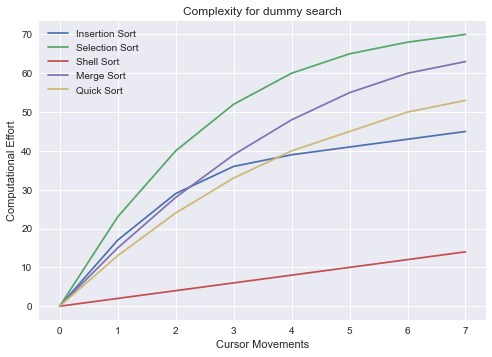

In [105]:
plt.plot(pub_df.Movements.values, pub_df.Effort.values, label='Insertion Sort')
plt.plot(pub_df2.Movements.values, pub_df2.Effort.values, label='Selection Sort')
plt.plot(pub_df3.Movements.values, pub_df3.Effort.values, label='Shell Sort')
plt.plot(pub_df4.Movements.values, pub_df4.Effort.values, label='Merge Sort')
plt.plot(pub_df5.Movements.values, pub_df5.Effort.values, label='Quick Sort')
plt.xlabel('Cursor Movements')
plt.ylabel('Computational Effort')
plt.title('Complexity for dummy search')
plt.legend()
plt.show()